### Using Opencv and Shapely in Python to Create Polygon Shapes from a Mask Image and then Back to a Mask from Polygons

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from scipy import misc
import cv2
from shapely.geometry import MultiPolygon, Polygon
from collections import defaultdict
from skimage.color import rgb2gray
import numpy as np
import json

%matplotlib inline

Monarch butterfly from Nat'l Geographic Kids (http://kids.nationalgeographic.com/animals/monarch-butterfly/#monarch-butterfly-grass.jpg)

In [3]:
img_file = 'monarch.jpg'

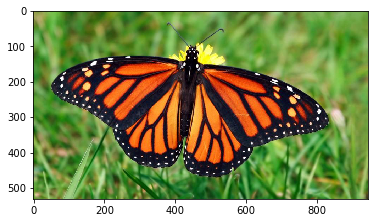

In [4]:
# Matplotlib reads as RGB
img_plt = plt.imread(img_file)
plt.imshow(img_plt)

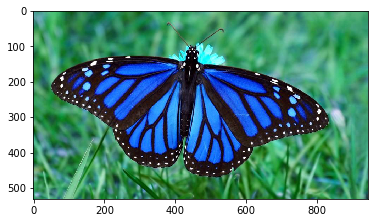

In [5]:
# Read as unchanged so that the transparency is not ignored as it would normally be by default
# Reads as BGR
img_cv2 = cv2.imread(img_file, cv2.IMREAD_UNCHANGED)
plt.imshow(img_cv2)

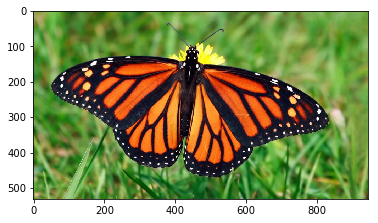

In [6]:
# Convert opencv BGR back to RGB
# See https://www.scivision.co/numpy-image-bgr-to-rgb/ for more conversions
rgb = img_cv2[...,::-1]
plt.imshow(rgb)

In [7]:
def mask_to_polygons(mask, epsilon=10., min_area=10.):
    # first, find contours with cv2: it's much faster than shapely
    image, contours, hierarchy = cv2.findContours(mask,
                                  cv2.RETR_CCOMP,
                                  cv2.CHAIN_APPROX_NONE)
    if not contours:
        return MultiPolygon()
    # now messy stuff to associate parent and child contours
    cnt_children = defaultdict(list)
    child_contours = set()
    assert hierarchy.shape[0] == 1
    # http://docs.opencv.org/3.1.0/d9/d8b/tutorial_py_contours_hierarchy.html
    for idx, (_, _, _, parent_idx) in enumerate(hierarchy[0]):
        if parent_idx != -1:
            child_contours.add(idx)
            cnt_children[parent_idx].append(contours[idx])
    # create actual polygons filtering by area (removes artifacts)
    all_polygons = []
    for idx, cnt in enumerate(contours):
        if idx not in child_contours and cv2.contourArea(cnt) >= min_area:
            assert cnt.shape[1] == 1
            poly = Polygon(
                shell=cnt[:, 0, :],
                holes=[c[:, 0, :] for c in cnt_children.get(idx, [])
                       if cv2.contourArea(c) >= min_area])
            all_polygons.append(poly)
    # approximating polygons might have created invalid ones, fix them
    all_polygons = MultiPolygon(all_polygons)
    if not all_polygons.is_valid:
        all_polygons = all_polygons.buffer(0)
        # Sometimes buffer() converts a simple Multipolygon to just a Polygon,
        # need to keep it a Multi throughout
        if all_polygons.type == 'Polygon':
            all_polygons = MultiPolygon([all_polygons])
    return all_polygons

In [8]:
def mask_for_polygons(polygons, im_size):
    img_mask = np.zeros(im_size, np.uint8)
    if not polygons:
        return img_mask
    int_coords = lambda x: np.array(x).round().astype(np.int32)
    exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
    interiors = [int_coords(pi.coords) for poly in polygons
                 for pi in poly.interiors]
    cv2.fillPoly(img_mask, exteriors, 1)
    cv2.fillPoly(img_mask, interiors, 0)
    return img_mask

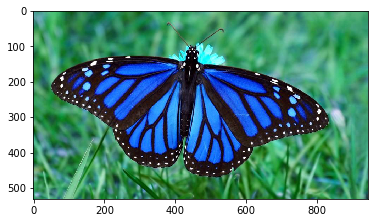

In [9]:
# Read in image unchanged
img = cv2.imread(img_file, cv2.IMREAD_UNCHANGED)

# View
plt.imshow(img)

Self-intersection at or near point 0 304


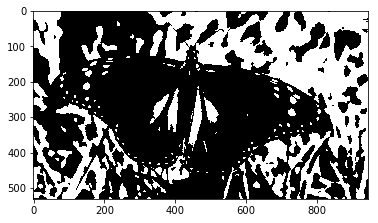

In [10]:
# Use the scikit-image method to convert to gray (flatten or binarize image)
BW = rgb2gray(img)

# Convert to CV_8UC1 for creating polygons with shapely
BW = cv2.convertScaleAbs(BW)

# Get the polygons using shapely
polys = mask_to_polygons(BW)

# Convert the polygons back to a mask image
mask = mask_for_polygons(polys, BW.shape[:2])

# View
plt.imshow(mask, cmap='gray', interpolation='nearest')

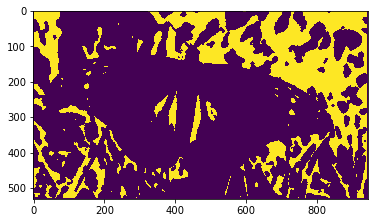

In [13]:
im2, contours, hierarchy = cv2.findContours(BW, cv2.RETR_CCOMP, cv2.CHAIN_APPROX_NONE)
plt.imshow(cv2.drawContours(im2, contours, -1, (0,255,0), 3))